 1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
  2. **PlannerState**: A custom type representing the state of our planning process.
  3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
  4. **LLM Integration**: Utilizing a language model to generate the final itinerary.

In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the

In [2]:
import os
from typing import TypedDict,Annotated,List
from langgraph.graph import StateGraph,END
from langchain_core.messages import HumanMessage,AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display,Image

DEFINE AGENT

In [3]:
class PlannerState(TypedDict):
  messages:Annotated[List[HumanMessage | AIMessage],"the messages in the conversation"]
  city:str
  interests:List[str]
  itinerary:str


In [4]:
from langchain_groq import ChatGroq
llm=ChatGroq(
    temperature=0,
    groq_api_key="***",#paste your api key
    model_name="llama-3.3-70b-versatile"
)


In [5]:
itinerary_prompt=ChatPromptTemplate.from_messages([
    ("system","You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human","Create an itinerary for my day trip."),
])

Define agent function

In [6]:
def input_city(state: PlannerState) -> PlannerState:
  print("please enter the city you want to visit for your day trip:")
  user_message=input("your input: ")
  return {
      **state,
      "city":user_message,
      "messages":state["messages"]+[HumanMessage(content=user_message)]
  }

def input_interests(state: PlannerState) -> PlannerState:
  print(f"please enter the interests you have for your day trip to:{state['city']} (comma-separated)")
  user_message=input("your input: ")
  return {
      **state,
      "interests":[interest.strip() for interest in user_message.split(",")],
      "messages":state["messages"]+[HumanMessage(content=user_message)]
  }

def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"creating an itinerary for {state['city']} based on interests:{', '.join(state['interests'])}"),
  response=llm.invoke(itinerary_prompt.format_messages(city=state["city"],interests=",".join(state["interests"])))
  print("\n Final itinerary:")
  print(response.content)
  return {
      **state,
      "messages":state["messages"]+[AIMessage(content=response.content)],
      "itinerary":response.content
  }

create and compile langgraph

In [7]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city",input_city)
workflow.add_node("input_interests",input_interests)
workflow.add_node("create_itinerary",create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city","input_interests")
workflow.add_edge("input_interests","create_itinerary")
workflow.add_edge("create_itinerary",END)


app=workflow.compile()

display the graph structure

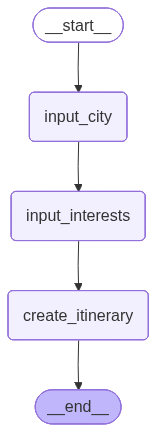

In [8]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

Define the function that runs the graph

In [9]:
def travel_planner(user_request:str):
  print(f"Initial request: {user_request}\n")
  state={
      "messages":[HumanMessage(content=user_request)],
      "city":"",
      "interests":[],
      "itinerary":"",
  }
  for output in app.stream(state):
    pass


In [10]:
user_request="I want to plan a day trip"
travel_planner(user_request)

Initial request: I want to plan a day trip

please enter the city you want to visit for your day trip:
your input: uttarakhad
please enter the interests you have for your day trip to:uttarakhad (comma-separated)
your input: kedarnath,badrinath,tugnath
creating an itinerary for uttarakhad based on interests:kedarnath, badrinath, tugnath

 Final itinerary:
Here's a brief, bulleted itinerary for a day trip to Uttarakhand based on your interests in Kedarnath, Badrinath, and Tungnath:

* 6:00 AM: Start the day with a visit to Tungnath Temple, the highest Shiva temple in the world (approx. 3-4 hours from Rudraprayag)
* 10:00 AM: Proceed to Guptkashi for a brief stop and snack break
* 12:00 PM: Head to Gaurikund, the base camp for Kedarnath (approx. 1 hour from Guptkashi)
* 1:00 PM: Have lunch at Gaurikund and explore the local market
* 2:30 PM: Visit the Kedarnath Temple (if time permits, or take a helicopter tour for a bird's-eye view)
* 5:00 PM: Drive to Badrinath (approx. 4-5 hours from G

creating interface

In [11]:
! pip install gradio

In [25]:
import gradio as gr

from typing import TypedDict,Annotated,List
from langgraph.graph import StateGraph,END
from langchain_core.messages import HumanMessage,AIMessage
from langchain_core.prompts import ChatPromptTemplate

from langchain_groq import ChatGroq

class PlannerState(TypedDict):
  messages:Annotated[List[HumanMessage | AIMessage],"the messages in the conversation"]
  city:str
  interests:List[str]
  itinerary:str

#define the llm
llm=ChatGroq(
    temperature=0,
    groq_api_key="***",#paste your api key
    model_name="llama-3.3-70b-versatile"
)

#define the itinerary prompt
itinerary_prompt=ChatPromptTemplate.from_messages([
    ("system","You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human","Create an itinerary for my day trip."),
])

# Redefine the helper functions to accept city and interests as direct inputs
def process_city(city: str, state: PlannerState) -> PlannerState:
  return {
      **state,
      "city": city,
      "messages": state["messages"] + [HumanMessage(content=f"City: {city}")]
  }

def process_interests(interests_str: str, state: PlannerState) -> PlannerState:
  interests = [interest.strip() for interest in interests_str.split(",")]
  return {
      **state,
      "interests": interests,
      "messages": state["messages"] + [HumanMessage(content=f"Interests: {interests_str}")]
  }

def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"creating an itinerary for {state['city']} based on interests:{', '.join(state['interests'])}"),
  response=llm.invoke(itinerary_prompt.format_messages(city=state["city"],interests=",".join(state["interests"])))
  print("\n Final itinerary:")
  print(response.content)
  return {
      **state,
      "messages":state["messages"]+[AIMessage(content=response.content)],
      "itinerary":response.content
  }

#define the Gradio application
def travel_planner(city:str,interests:str):
  #initialize state
  state={
      "messages":[],
      "city":"",
      "interests":[],
      "itinerary":"",
  }

  #process the city and interests inputs
  state=process_city(city,state)
  state=process_interests(interests,state)

  #create the itinerary
  itinerary_state = create_itinerary(state)

  #return the itinerary
  return itinerary_state["itinerary"]

#build the gradio interface
interface=gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the City for your day trip"),
        gr.Textbox(label="Enter your Interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary",lines=10,autoscroll=False),
    title="Travel Itinerary Planner",
    description="Enter a city and your intersts to generate specialized day trip itinerary"
)

interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0d1a1e81519091ba6c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
